# **\[Essays\]** 강화학습(3) – LunarLander

신록예찬  
2023-08-30

# imports

In [48]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
import collections
import IPython
import random

# 예비학습

`-` collections.deque의 기능

In [49]:
a = collections.deque([1,2,3],maxlen=5)
a

In [50]:
a.append(4)

In [51]:
a

In [52]:
a.append(5)

In [53]:
a

In [54]:
a.append(6)

In [55]:
a

`-` 단점?: numpy array 보다는 list 느낌임 (연산에 특화된건 아님)

In [56]:
a+1

`-` 그렇지만 언제든지 numpy화 가능

In [57]:
np.array(a)+1

`-` collection.deque는 리플레이 버퍼를 구현할때 유리한 자료구조이다.

-   (우리가 했던) 기존방식: 모든 데이터를 저장하며 한번의 경험씩 학습함
-   리플레이버퍼: 최근의 데이터를 저장하며 여러경험을 샘플링하여 학습함
-   리플레이버퍼의 장점: 메모리를 아낄 수 있다, 다양한 종류의 경험을
    저장하고 무작위로 재사용하여 안정성이 높다, “저장 -\> 학습 -\> 저장”
    순으로 반드시 실시간학습을 할 필요가 없어 병렬처리에 용이하다,
    강화학습에서의 연속된 경험은 상관관계가 있을 수 있는데 무작위 샘플로
    이를 제거할 수 있다 등등~

# Game3: LunarLander

`-` 환경생성

In [58]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')

`-` state_space

In [59]:
env.observation_space

`-` action_space

In [60]:
env.action_space

`-` env.reset()

In [61]:
env.reset()

`-` env.render()

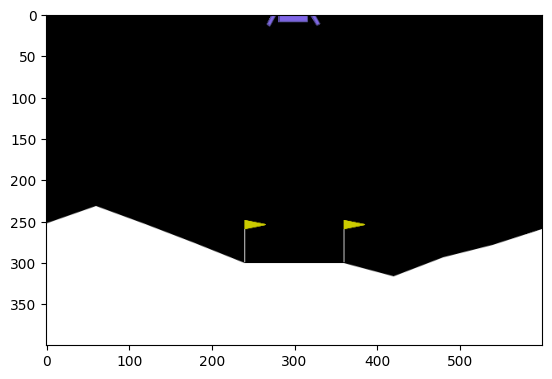

In [62]:
plt.imshow(env.render())

`-` env.step

In [63]:
for _ in range(5):
    env.step(0)
    env.step(2)
    env.step(2)
    env.step(1)

-   0: 정지
-   1: 왼쪽
-   2: 위로
-   3: 오른쪽
-   <https://gymnasium.farama.org/environments/box2d/lunar_lander/>

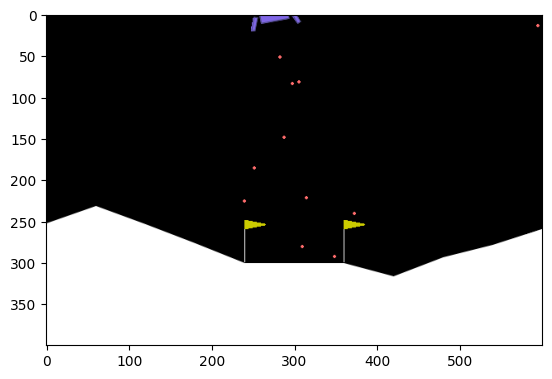

In [64]:
plt.imshow(env.render())

# 시각화

In [65]:
env.step(0)

In [66]:
current_states = collections.deque(maxlen=50)
actions = collections.deque(maxlen=50)
next_states = collections.deque(maxlen=50) 
rewards = collections.deque(maxlen=50) 
terminations = collections.deque(maxlen=50)
ims = []
current_state, _ = env.reset()

for t in range(500):
    action = env.action_space.sample()
    next_state, reward, terminated, _, _ = env.step(action)
    im = env.render()
    
    current_states.append(current_state)
    actions.append(action)
    next_states.append(next_state)
    rewards.append(reward) 
    terminations.append(terminated)
    ims.append(im)    

    current_state = next_state 
    if terminated: break

In [67]:
def show(ims,jump=10):
    ims = ims[::jump]
    fig = plt.Figure()
    ax = fig.subplots()
    def update(i):
       ax.imshow(ims[i])
    ani = FuncAnimation(fig,update,frames=len(ims))
    display(IPython.display.HTML(ani.to_jshtml()))

In [68]:
show(ims,jump=10)

# `q_net`

`-` 데이터를 모아보자.

In [69]:
current_states = collections.deque(maxlen=50) 
actions = collections.deque(maxlen=50) 
next_states = collections.deque(maxlen=50) 
rewards = collections.deque(maxlen=50) 
terminations = collections.deque(maxlen=50) 

current_state, _ = env.reset()
for t in range(500): 
    action = env.action_space.sample()
    next_state, reward, terminated, _, _ = env.step(action)

    current_states.append(current_state) 
    actions.append(action)
    next_states.append(next_state)
    rewards.append(reward)
    terminations.append(terminated) 
    
    current_state = next_state 
    if terminated: break 

`-` 이전코드에서 아래에 대응하는 부분을 잘 구현하면 된다.

``` python
## 1. q[x,y,a] 
agent.q = np.zeros([4,4,4])  

## 2. q_estimate  
x,y = agent.current_state
xx,yy = agent.next_state
a = agent.action 
q_estimated = agent.q[x,y,a] 

## 3. q_realistic = reward + 0.99 * q_future
if agent.terminated:
    q_realistic = agent.reward
else:
    q_future = q[xx,yy,:].max()
    q_realistic = agent.reward + 0.99 * q_future

## 4. q_estimate 와 q_realistic 를 비슷하게 만들어주는 역할을 하는 코드 
diff = q_realistic - q_estimated 
agent.q[x,y,a] = q_estimated + 0.05 * diff
```

`1`. q_net를 설정

In [70]:
q_net = torch.nn.Sequential(
    torch.nn.Linear(8,128), # 8개의 상태공간 
    torch.nn.ReLU(),
    torch.nn.Linear(128,64), 
    torch.nn.ReLU(),
    torch.nn.Linear(64,32), 
    torch.nn.ReLU(),
    torch.nn.Linear(32,4) # 4개의 action값들 
)

In [71]:
torch.tensor(current_state)

In [72]:
q_net(torch.tensor(current_state))

`1`. q_net를 설정 (배치버전)

– get batch –

In [73]:
batch_size = 4
idx = np.random.randint(0,50,size=batch_size) 
idx

In [74]:
torch.tensor(current_states)[idx]

In [75]:
torch.tensor(np.array(current_states))[idx]

In [76]:
current_states_batch = torch.tensor(np.array(current_states))[idx].float()
actions_batch = torch.tensor(np.array(actions))[idx].reshape(batch_size,1)
rewards_batch = torch.tensor(np.array(rewards))[idx].reshape(batch_size,-1).float()
next_states_batch = torch.tensor(np.array(next_states))[idx].float()
terminations_batch = torch.tensor(np.array(terminations))[idx].reshape(batch_size,-1) 

In [77]:
~terminations_batch

– q_net –

In [78]:
q_net(current_states_batch)

`2`. q_estimated의 구현

In [79]:
q_net(current_states_batch), actions_batch

In [80]:
q_estimated = q_net(current_states_batch).gather(1,actions_batch)
q_estimated

`3`. q_realistic = reward + 0.99 \* q_future 의 구현

**q_future**

In [81]:
q_future = q_net(next_states_batch).max(axis=1)[0].reshape(batch_size,1)
q_future

In [82]:
q_realistic = rewards_batch + q_future * 0.99 * (~terminations_batch)

`4`. `q_estimated` $\approx$ `q_realistic` 가 되도록 만드는 장치

``` python
## 여기는.. 딥러닝과 파이토치를 좀 알아야.. 모른다면 일단 패스해야해요
optimizer = torch.optim.Adam(q_net.parameters(), lr=0.0001)
for _ in range(2000):
    ~~
    ~~
    q_estimated = ...
    q_observed = ... 
    loss = torch.nn.functional.mse_loss(q_estimated, q_observed)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
```

# policy

In [83]:
eps = 0.5 
if np.random.rand() > eps:
    action = q_net(torch.tensor(current_state)).argmax().item()
else:
    action = env.action_space.sample()

In [84]:
action

# Agent 클래스 + run

In [85]:
class Agent():
    def __init__(self,env):
        self.eps = 0
        self.n_experiences = 0
        self.n_episode = 0
        self.score = 0
        self.scores = [] 
        self.playtimes = []
        self.batch_size = 64
        self.buffer_size = 5000 
        self.action_space = env.action_space
        #self.state_space = env.observation_space

        # Q-Network
        self.q_net = torch.nn.Sequential(
            torch.nn.Linear(8,128), 
            torch.nn.ReLU(),
            torch.nn.Linear(128,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,4)
        ) 
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=0.0001)

        # ReplayBuffer
        self.memory = collections.deque(maxlen=self.buffer_size)
        self.current_states = collections.deque(maxlen=self.buffer_size)
        self.actions = collections.deque(maxlen=self.buffer_size)
        self.rewards = collections.deque(maxlen=self.buffer_size)
        self.next_states = collections.deque(maxlen=self.buffer_size)
        self.terminations = collections.deque(maxlen=self.buffer_size)
       
    def save_experience(self):
        """Add a new experience to memory."""
        self.current_states.append(self.current_state)
        self.actions.append(self.action)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated) 
        self.n_experiences = self.n_experiences+1
        self.score += self.reward
    
    def act(self):
        if np.random.rand() < self.eps:
            self.action = self.action_space.sample()
        else:
            self.action = self.q_net(torch.tensor(self.current_state)).argmax().item()
            
    def get_batch(self):
        idx = np.random.randint(0,self.buffer_size,size=self.batch_size) 
        self.current_states_batch = torch.tensor(np.array(self.current_states))[idx].float()
        self.actions_batch = torch.tensor(np.array(self.actions))[idx].reshape(self.batch_size,1)
        self.rewards_batch = torch.tensor(np.array(self.rewards))[idx].reshape(self.batch_size,-1).float()
        self.next_states_batch = torch.tensor(np.array(self.next_states))[idx].float()
        self.terminations_batch = torch.tensor(np.array(self.terminations))[idx].reshape(self.batch_size,-1) 
    
    def learn(self):
        if self.n_experiences < self.buffer_size:
            pass
        else: 
            self.get_batch()
            q_estimated = self.q_net(self.current_states_batch).gather(1, self.actions_batch)
            q_future = self.q_net(self.next_states_batch).detach().max(1)[0].reshape(self.batch_size,1)
            q_realistic = self.rewards_batch + 0.99 * q_future * (~self.terminations_batch)

            loss = torch.nn.functional.mse_loss(q_estimated, q_realistic)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

In [87]:
env = gym.make('LunarLander-v2',render_mode='rgb_array')
agent = Agent(env)
agent.eps = 1.0 
for _ in range(2000):
    ### 1. 본질적인 코드
    agent.current_state, _  = env.reset() 
    agent.terminated = False
    agent.score = 0 
    for t in range(500):
        # step1: agent >> env 
        agent.act() 
        env.agent_action = agent.action  
        # step2: agent << env 
        agent.next_state, agent.reward, agent.terminated, _,_ = env.step(env.agent_action)
        agent.save_experience() 
        # step3: learn 
        agent.learn()
        # step4: state update 
        agent.current_state = agent.next_state 
        # step5: 
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episode = agent.n_episode + 1 
    agent.eps = agent.eps*0.995
    ## 2. 비본질적 코드
    if (agent.n_episode % 10) == 0:
        print(
            f'Episode {agent.n_episode}\t'
            f'Score: {np.mean(agent.scores[-100:]) : .2f}\t'
            f'Playtime: {np.mean(agent.playtimes[-100:]) : .2f}\t'
            f'n_eps: {agent.eps}\t'
            f'n_experiences: {agent.n_experiences}\t'
        )
    if np.mean(agent.scores[-100:])>=200.0:
        break

Episode 10  Score: -137.90  Playtime:  97.10    n_eps: 0.9511101304657719   n_experiences: 971  
Episode 20  Score: -195.78  Playtime:  96.60    n_eps: 0.9046104802746175   n_experiences: 1932 
Episode 30  Score: -196.55  Playtime:  92.40    n_eps: 0.8603841919146962   n_experiences: 2772 
Episode 40  Score: -201.82  Playtime:  90.53    n_eps: 0.8183201210226743   n_experiences: 3621 
Episode 50  Score: -217.03  Playtime:  90.06    n_eps: 0.778312557068642    n_experiences: 4503 
Episode 60  Score: -224.53  Playtime:  90.13    n_eps: 0.7402609576967045   n_experiences: 5408 
Episode 70  Score: -216.98  Playtime:  90.06    n_eps: 0.7040696960536299   n_experiences: 6304 
Episode 80  Score: -228.78  Playtime:  94.11    n_eps: 0.6696478204705644   n_experiences: 7529 
Episode 90  Score: -220.73  Playtime:  97.60    n_eps: 0.6369088258938781   n_experiences: 8784 
Episode 100 Score: -217.57  Playtime:  103.18   n_eps: 0.6057704364907278   n_experiences: 10318    
Episode 110 Score: -218.36

In [89]:
agent2 = Agent(env)
agent2.current_state,_ = env.reset()

agent2.q_net = agent.q_net
agent2.terminated = False
ims = [] 
ims.append(env.render())
for t in range(500):
    agent2.act()
    agent2.next_state, agent2.reward, agent2.terminated,_ , _ = env.step(agent2.action)
    agent2.current_state = agent2.next_state 
    ims.append(env.render())
    if agent2.terminated: break 

In [90]:
show(ims,jump=10)